*Please name your Example notebook as transparently as possible. Feel free to add a description of the workflow's goal. [Remove this line when creating your example]*

# Example Notebook Template

**Author of this template** : Michèle Masson-Trottier [Remove this line when creating your example]

**Author**: 
*Include the name of all authors of the workflow showcased in the example notebook*.

**Date**:

### Citation and Resources:
*Please include the citations for all tools, software, and publications referenced in the workflow. If you are basing your workflow on another previously published example notebook, please cite the name and DOI.*

#### Tools included in this workflow
*Cite the tools based on their preferred method (example through a Zenodo DOI or a publication)*

#### Workflows this work is based on (if applicable)
*If you started from another published workflow, please cite it here*

#### Publications
*Any publication that helped you build your example should be cited here*

#### Educational resources
*Any educational resource (for example Andy's Brain Book, FSL tutorials...) should be cited here.*

#### Dataset
*Please cite the database and dataset used in your example*

**Optional:** Add a Table of Contents (ToC) below if it helps navigation during interactive use on Neurodesk. 
When rendered on GitHub Pages, a sidebar ToC is already available, so an inline ToC may be unnecessary.

Each link must match a corresponding section heading: ` ## 1. Data Preparation → #1-Data-Preparation` (keep spaces as hyphens, preserve capital letters), as demonstrated in the next cell.


[Remove this cell when creating your example]

## Table of content
[1. Data Preparation](#1.-Data-Preparation)  
[2. Analysis](#2.-Analysis)  
[3. Results](#3.-Results) 

[Remove this cell if no ToC is used in your notebook]

## Load software tools and import python libraries

Please have a bloc for loading the different modules needed for your example. If you can not find all the required tools in Neurodesk, feel free to add tools using the web-based GUI https://www.neurodesk.org/neurocontainers-ui/

In [1]:
#load FSL 6.0.4
import module
await module.load('fsl/6.0.4')
await module.list()

ModuleNotFoundError: No module named 'module'

Please consult the python packages included in the base image [see list here](https://github.com/neurodesk/neurodesktop/blob/main/Dockerfile). If you are using python packages different than these, be sure to `pip install` them in the workflow.

In [ ]:
%%capture 
!pip install pydicom

In [ ]:
# Import the necessary libraries
import pydicom # Library to work with DICOM files
import matplotlib.pyplot as plt # Plotting library for displaying images
import os # Standard library to interact with the filesystem

## 1. Data Preparation
*Please indicate clearly where the data is sourced. In this template, there's an example for Datalad and OSF*

# Our code (not neurodesk template) :
# START TO RUN FROM HERE, IGNORE CELLS ABOVE

In [3]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 20:36:50.988: Failed to load module "canberra-gtk-module"


In [4]:
anatomical_path = op.join("subject101410", "T1w", "T1w.nii.gz") #the original brain
subject_id = '101410'

In [5]:
derivatives = op.join("derivatives", "preprocessed_data", "subject_101410")
deriv_anat = op.join(derivatives, "anat")
deriv_func = op.join(derivatives, "func")

for d in (deriv_anat, deriv_func):
    os.makedirs(d, exist_ok=True)

print("Derivatives will be written to:", os.path.abspath(derivatives))

Derivatives will be written to: /data/derivatives/preprocessed_data/subject_101410


In [6]:
#bids_root   = "/data/NX-NSSP"  
#preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
#deriv_root = op.join(bids_root, 'derivatives')

In [7]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

20:36:53: Debug: Adding duplicate image handler for 'Windows bitmap file'
20:36:53: Debug: Adding duplicate animation handler for '1' type
20:36:53: Debug: Adding duplicate animation handler for '2' type
20:36:53: Debug: Adding duplicate image handler for 'Windows bitmap file'
20:36:53: Debug: Adding duplicate animation handler for '1' type
20:36:53: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:8866): Gtk-CRITICAL **: 20:36:53.776: gtk_window_resize: assertion 'height > 0' failed


In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anatomical_path)


(ipykernel_launcher.py:8866): Gdk-WARNING **: 20:36:54.600: gdkdrawable-x11.c:952 drawable is not a pixmap or window
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8866): Gdk-WARNING **: 20:36:54.601: gdkdrawable-x11.c:952 drawable is not a pixmap or window
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8866): Gdk-WARNING **: 20:36:54.602: gdkdrawable-x11.c:952 drawable is not a pixmap or window
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown
20:36:54: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:8866): Gdk-WARNING **: 20:36:54.603: gdkdrawable-x11.c:952 drawable is not a pixmap or window
20:36:54: Debug: ClientToScreen cannot work when toplevel wi

## 1)a) Skull-stripping

In [9]:
def get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    betted_brain_path = op.join(deriv_anat, 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=True)

Done with BET.


In [10]:
fsleyesDisplay.load(resulting_mask_path)

In [11]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    
betted_brain_path = op.join(deriv_anat, 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)


(ipykernel_launcher.py:8866): Gdk-WARNING **: 20:37:22.177: gdkdrawable-x11.c:952 drawable is not a pixmap or window


## 1)b) Segmentation

In [ ]:
bet_path = op.join(deriv_anat, 'sub-101410_T1w')
fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(deriv_anat, '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(deriv_anat, 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

pve_0 is CSF, pve_1 is grey matter, pve_2 is white matter

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## 2)a) Concatenation

In [13]:
#prochaine run commence à 189+15.5

functional_path_LR = op.join("subject101410", "fMRI", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_LR.nii") 
functional_path_RL = op.join("subject101410", "fMRI", "tfMRI_MOTOR_RL", "tfMRI_MOTOR_RL.nii") 
print("Functional paths have been created")

Functional paths have been created


In [ ]:
###########################################
# Normalisation de variance - Run LR
###########################################
print("Normalizing variance for LR run")

img_LR = nib.load(functional_path_LR)
data_LR = img_LR.get_fdata()
affine_LR = img_LR.affine
header_LR = img_LR.header

mask_img = nib.load(resulting_mask_path)            # charge le fichier du masque depuis le disque
mask_data = mask_img.get_fdata().astype(bool)       # convertit en tableau booléen (True = voxels du cerveau)

# Vérifie que le masque et les données fonctionnelles ont la même taille
if mask_data.shape != data_LR.shape[:3]:
    print("Dimensions mismatch: resampling mask for LR run.")
    resampled_mask_LR = op.join(deriv_func, "mask_LR_resampled.nii.gz")
    subprocess.run(["flirt", "-in", resulting_mask_path, "-ref", functional_path_LR, "-applyxfm", "-usesqform", "-out", resampled_mask_LR], check=True)
    mask_data = nib.load(resampled_mask_LR).get_fdata().astype(bool)

# Calcul de la variance globale sur les voxels du cerveau
brain_voxels_LR = data_LR[mask_data]
var_voxels_LR = brain_voxels_LR.var(axis=1)
global_var_LR = var_voxels_LR.mean()
scale_LR = 1 / np.sqrt(global_var_LR)
print(f"Global variance (LR): {global_var_LR:.6g}, scale factor: {scale_LR:.6g}")

# Normalisation
data_LR_scaled = data_LR * scale_LR

# Sauvegarde
scaled_LR_path = op.join(deriv_func, "tfMRI_MOTOR_LR_varscaled.nii.gz")
nib.save(nib.Nifti1Image(data_LR_scaled.astype(np.float32), affine_LR, header_LR), scaled_LR_path)
print(f"Saved normalized LR run: {scaled_LR_path}\n")

###########################################
# Normalisation de variance - Run RL
###########################################
print("Normalizing variance for RL run")

img_RL = nib.load(functional_path_RL)
data_RL = img_RL.get_fdata()
affine_RL = img_RL.affine
header_RL = img_RL.header

if mask_data.shape != data_RL.shape[:3]:
    print("Dimensions mismatch: resampling mask for RL run.")
    resampled_mask_RL = op.join(deriv_func, "mask_RL_resampled.nii.gz")
    subprocess.run(["flirt", "-in", resulting_mask_path, "-ref", functional_path_RL, "-applyxfm", "-usesqform", "-out", resampled_mask_RL], check=True)
    mask_data = nib.load(resampled_mask_RL).get_fdata().astype(bool)

brain_voxels_RL = data_RL[mask_data]
var_voxels_RL = brain_voxels_RL.var(axis=1)
global_var_RL = var_voxels_RL.mean()
scale_RL = 1 / np.sqrt(global_var_RL)
print(f" Global variance (RL): {global_var_RL:.6g}, scale factor: {scale_RL:.6g}")

data_RL_scaled = data_RL * scale_RL

scaled_RL_path = op.join(deriv_func, "tfMRI_MOTOR_RL_varscaled.nii.gz")
nib.save(nib.Nifti1Image(data_RL_scaled.astype(np.float32), affine_RL, header_RL), scaled_RL_path)
print(f" Saved normalized RL run: {scaled_RL_path}\n")

###########################################
# Concaténation temporelle des deux runs
###########################################
print(" Concatenating normalized runs...")

img_LR_scaled = nib.load(scaled_LR_path)
img_RL_scaled = nib.load(scaled_RL_path)

concat_img = nib.concat_images([img_LR_scaled, img_RL_scaled], axis=-1)
concat_path = op.join(deriv_func, f"sub-{subject_id}_motor_concat_varscaled.nii.gz")

nib.save(concat_img, concat_path)
print(f" Done! Final concatenated file: {concat_path}")


## 2)b) Motion correction

In [18]:
from fsl.wrappers import mcflirt

path_motioncorr_LR = op.join(deriv_func, "tfMRI_MOTOR_LR_motioncorrected")            # path to the motion corrected file
path_motioncorr_RL = op.join(deriv_func, "tfMRI_MOTOR_RL_motioncorrected")            # path to the motion corrected file

mcflirt(infile=functional_path_LR, o=path_motioncorr_LR, plots=True, report=True, dof=6, mats=True)
print("Motor LR corrected")
mcflirt(infile=functional_path_RL, o=path_motioncorr_RL, plots=True, report=True, dof=6, mats=True)
print("Motor RL corrected")

Processed data will be saved as derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_LR_motioncorrected

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283]

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

Motor LR corrected


Processed data will be saved as derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_RL_motioncorrected

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283]

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

Motor RL corrected


In [2]:
# Cell to run if save is not possible anymore

import shutil
import os

folder_to_clear = "derivatives/preprocessed_data/subject_101410"
if os.path.exists(folder_to_clear):
    shutil.rmtree(folder_to_clear)
    print("Dossier supprimé pour libérer de l'espace.")

Dossier supprimé pour libérer de l'espace.


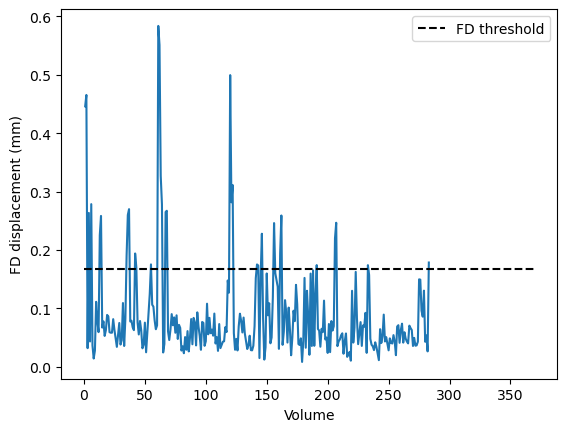

Indices of frames above threshold: [1, 2, 4, 6, 13, 14, 35, 36, 37, 42, 43, 55, 61, 62, 63, 64, 67, 68, 120, 121, 122, 142, 143, 146, 156, 161, 162, 191, 206, 207, 233, 283]


In [21]:
import matplotlib.pyplot as plt

lr_par_path = op.join(deriv_func, 'tfMRI_MOTOR_LR_motioncorrected.par')
rl_par_path = op.join(deriv_func, 'tfMRI_MOTOR_RL_motioncorrected.par')

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(lr_par_path)
mot_params

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rotation_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    
    convert_rot_to_arc = rotation_params*50             # transform from angle to arc of circle for a radius of 50mm
    translation_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = convert_rot_to_arc.abs().sum(axis=1) + translation_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

print(f"Indices of frames above threshold: {(np.where(fd > threshold)[0] + 1).tolist()}")

## 2)c) Co-registration (bonus)

## 2)d) Gaussian smoothing

# END OF OUR CODE, BELOW IS THE NEURODESK TEMPLATE (IGNORE BELOW)

### Datalad

In [ ]:
%%bash

# Install the dataset from GitHub using DataLad. 
# Replace the URL with the one corresponding to the OpenNeuro dataset you want to use.
datalad install https://github.com/OpenNeuroDatasets/ds000102.git 

# Navigate into the dataset directory. 
# This should match the name of the dataset repository.
cd ds000102

# Optional: List available subjects
ls -d sub-*

# Download data for a specific subject (e.g., sub-08).
# You can change the subject ID to the one you're interested in.
datalad get sub-08

### OSF

In [ ]:
# Use the OSF client to clone the contents of the OSF project with ID 'ru43c' into the current directory
# The output is suppressed for cleaner display using > /dev/null 2>&1
!osf -p ru43c clone . > /dev/null 2>&1

# Extract the contents of the downloaded tar archive, which contains DICOM files
!tar xf osfstorage/dicoms-unsorted.tar

# Remove the now-unneeded 'osfstorage' directory to keep things tidy
!rm -rf osfstorage/

# Display the top of the folder tree for the extracted DICOM files (limited with `head` to avoid overwhelming output)
!tree dicoms-unsorted | head

# Print a count of how many unsorted DICOM files were extracted
!echo -e "...\nThere are `ls dicoms-unsorted | wc -l` unsorted DICOMs in ./dicoms-unsorted/"

### Visualisation of a dicom (one method for example)

In [ ]:
# Define the path to a DICOM file
# You can change this to any other file in the dicoms-unsorted/ directory
dcm_path = "./dicoms-unsorted/MR.1.2.276.0.7230010.3.1.3.0.4480.1677042698.772469.84.dcm"

# Read the DICOM file into a Python object
ds = pydicom.dcmread(dcm_path)

# ----------------------------
# Inspecting DICOM metadata (optional)
# ----------------------------

# Print a few key metadata fields (can be useful for QC or orientation)
print("Patient ID:", ds.get("PatientID", "N/A"))
print("Modality:", ds.get("Modality", "N/A"))
print("Study Date:", ds.get("StudyDate", "N/A"))

# ----------------------------
# Visualizing the DICOM image
# ----------------------------

# Display the image stored in the DICOM file using matplotlib
# Note: Some DICOM files (e.g., non-image series) may not contain pixel data
plt.imshow(ds.pixel_array, cmap=plt.cm.gray) # Use grayscale color map
plt.title("DICOM Slice: MR.1.1.dcm") # Title of the plot
plt.axis("off") # Hide axis ticks/labels for cleaner view
plt.show()

## 2. Analysis

*Be sure to annotate your example. You can also add Markdown blocs to provide explanations.*

In [ ]:
!bet ./ds000102/sub-08/anat/sub-08_T1w.nii.gz sub-08_T1w_brain.nii.gz

## 3. Results

In [ ]:
from ipyniivue import NiiVue
nv = NiiVue()
nv.load_volumes([{"path": "sub-08_T1w_brain.nii.gz"}])
nv

## Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [ ]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions